<a href="https://colab.research.google.com/github/TheGooseGuy/Recipe-Classification/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
import requests
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
train_data_url = "https://github.com/TheGooseGuy/Recipe-Classification/raw/main/Data/train.json"
test_data_url = "https://github.com/TheGooseGuy/Recipe-Classification/raw/main/Data/test.json"

train_data_response = requests.get(train_data_url)
test_data_response = requests.get(test_data_url)

train_data = pd.DataFrame(json.loads(train_data_response.text))
test_data = pd.DataFrame(json.loads(test_data_response.text))

# Exploratory Data Analysis (EDA)

## Data Structure

In [3]:
print("Train dataset:", train_data.shape)
print(train_data.head(20))
print("")
print("Test dataset:", test_data.shape)
print(test_data.head(20))

Train dataset: (39774, 3)
       id      cuisine                                        ingredients
0   10259        greek  [romaine lettuce, black olives, grape tomatoes...
1   25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2   20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3   22213       indian                [water, vegetable oil, wheat, salt]
4   13162       indian  [black pepper, shallots, cornflour, cayenne pe...
5    6602     jamaican  [plain flour, sugar, butter, eggs, fresh ginge...
6   42779      spanish  [olive oil, salt, medium shrimp, pepper, garli...
7    3735      italian  [sugar, pistachio nuts, white almond bark, flo...
8   16903      mexican  [olive oil, purple onion, fresh pineapple, por...
9   12734      italian  [chopped tomatoes, fresh basil, garlic, extra-...
10   5875      italian  [pimentos, sweet pepper, dried oregano, olive ...
11  45887      chinese  [low sodium soy sauce, fresh ginger, dry musta...
12   2698   

In [4]:
print(train_data.info())

print("")

print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB
None


Train dataset has 3 columns, "id", "cuisine", and "ingredients". It has 39774 rows.  
Test dataset has 2 colums, "id" and "ingredients". It has 9944 rows. We have to predict the "cuisine" column in this dataset.

## Analyze Ingredient Frequency and Variety

In [5]:
from collections import Counter

# Flatten the list of ingredients
all_ingredients = [ingredient for sublist in train_data['ingredients'] for ingredient in sublist]
ingredient_counts = Counter(all_ingredients)

# Top 20 most common ingredients
print("Top 10 most common ingredients:")
for i in ingredient_counts.most_common(20):
    print(f"{i[0]}: {i[1]}")

print("")

# Bottom 10 least common ingredients
print("Bottom 10 least common ingredients:")
for i in ingredient_counts.most_common()[-10:]:
    print(f"{i[0]}: {i[1]}")

Top 10 most common ingredients:
salt: 18049
onions: 7972
olive oil: 7972
water: 7457
garlic: 7380
sugar: 6434
garlic cloves: 6237
butter: 4848
ground black pepper: 4785
all-purpose flour: 4632
pepper: 4438
vegetable oil: 4385
eggs: 3388
soy sauce: 3296
kosher salt: 3113
green onions: 3078
tomatoes: 3058
large eggs: 2948
carrots: 2814
unsalted butter: 2782

Bottom 10 least common ingredients:
Oscar Mayer Cotto Salami: 1
Challenge Butter: 1
orange glaze: 1
cholesterol free egg substitute: 1
ciabatta loaf: 1
Lipton® Iced Tea Brew Family Size Tea Bags: 1
Hidden Valley® Greek Yogurt Original Ranch® Dip Mix: 1
lop chong: 1
tomato garlic pasta sauce: 1
crushed cheese crackers: 1


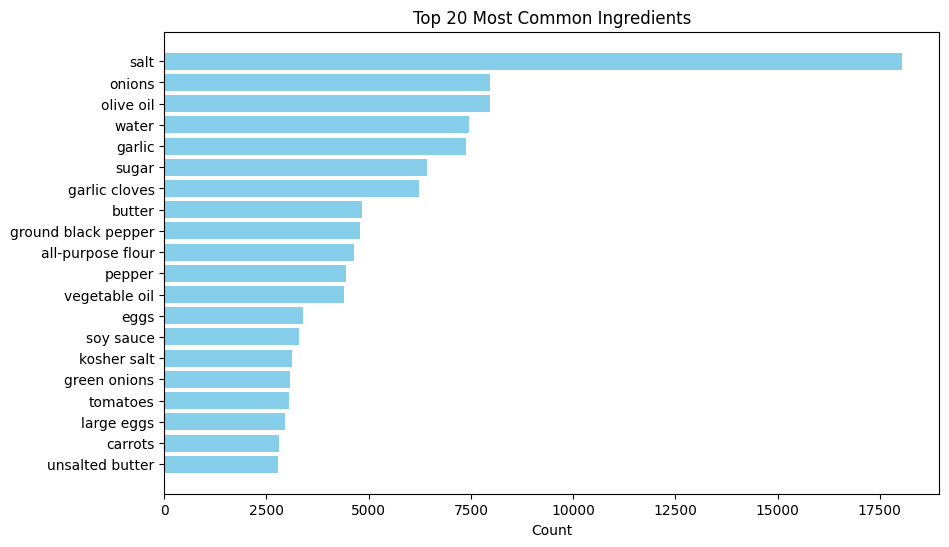

In [6]:
# Bar plot for top ingredients
top_ingredients = ingredient_counts.most_common(20)
ingredients, counts = zip(*top_ingredients)

plt.figure(figsize=(10, 6))
plt.barh(ingredients, counts, color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Common Ingredients')
plt.gca().invert_yaxis()
plt.show()

## Missing or Unusual Data

In [7]:
print(train_data.isnull().sum())

print("")

print(test_data.isnull().sum())

id             0
cuisine        0
ingredients    0
dtype: int64

id             0
ingredients    0
dtype: int64


Both train dataset and test dataset has no missing value.

In [8]:
# Find rows with empty ingredient lists
empty_ingredients = train_data[train_data['ingredients'].apply(len) == 0]
print(f"Number of recipes with no ingredients: {len(empty_ingredients)}")

Number of recipes with no ingredients: 0


## Class Distribution

In [9]:
cuisine_counts = train_data['cuisine'].value_counts()
print(cuisine_counts)

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64


The classes are significantly unbalanced, Italian cuisines has about 20 times entries as Brazilian ones. However, whether use resampling or not should be decided by model choice as different model has different sensitivity to class imbalance.

# Preprocessing

In [10]:
train_data['is_train'] = 1
test_data['is_train'] = 0

# Combine train and test data for preprocessing
combined_data = pd.concat([train_data, test_data], ignore_index=True)

## Text Cleaning

In [11]:
# Initialize tools for stemming
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_ingredients(ingredients):
    cleaned = []
    for ingredient in ingredients:
        # Lowercase
        ingredient = ingredient.lower()
        # Remove special characters
        ingredient = re.sub(r'[^a-z\s]', '', ingredient)
        # Tokenize and remove stopwords
        tokens = word_tokenize(ingredient)
        tokens = [word for word in tokens if word not in stop_words]

        cleaned.append(" ".join(tokens))
    return cleaned

combined_data['cleaned_ingredients'] = combined_data['ingredients'].apply(clean_ingredients)

In [12]:
print(combined_data.head(5))

      id      cuisine                                        ingredients  \
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3  22213       indian                [water, vegetable oil, wheat, salt]   
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...   

   is_train                                cleaned_ingredients  
0         1  [romaine lettuce, black olives, grape tomatoes...  
1         1  [plain flour, ground pepper, salt, tomatoes, g...  
2         1  [eggs, pepper, salt, mayonaise, cooking oil, g...  
3         1                [water, vegetable oil, wheat, salt]  
4         1  [black pepper, shallots, cornflour, cayenne pe...  


## Convert Ingredients to Text Data

In [13]:
# Combine ingredients into a single string for each row
combined_data['ingredients_text'] = combined_data['cleaned_ingredients'].apply(lambda x: ' '.join(x))

## Feature Engineering

In [14]:
combined_data['ingredient_count'] = combined_data['cleaned_ingredients'].apply(len)

## Summary

In [15]:
print(combined_data.head(5))

      id      cuisine                                        ingredients  \
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3  22213       indian                [water, vegetable oil, wheat, salt]   
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...   

   is_train                                cleaned_ingredients  \
0         1  [romaine lettuce, black olives, grape tomatoes...   
1         1  [plain flour, ground pepper, salt, tomatoes, g...   
2         1  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3         1                [water, vegetable oil, wheat, salt]   
4         1  [black pepper, shallots, cornflour, cayenne pe...   

                                    ingredients_text  ingredient_count  
0  romaine lettuce black olives grape tomatoes ga...                 9  


In [16]:
train_data = combined_data[combined_data['is_train'] == 1]
test_data = combined_data[combined_data['is_train'] == 0]

# Modelling

In [19]:
from sklearn.model_selection import train_test_split

X = train_data[['ingredients', 'ingredients_text', 'ingredient_count']]  # Adjust based on chosen features
y = train_data['cuisine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

## Logistic Regression

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train['ingredients_text'], y_train)

# Evaluate the model
accuracy = pipeline.score(X_test['ingredients_text'], y_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.78


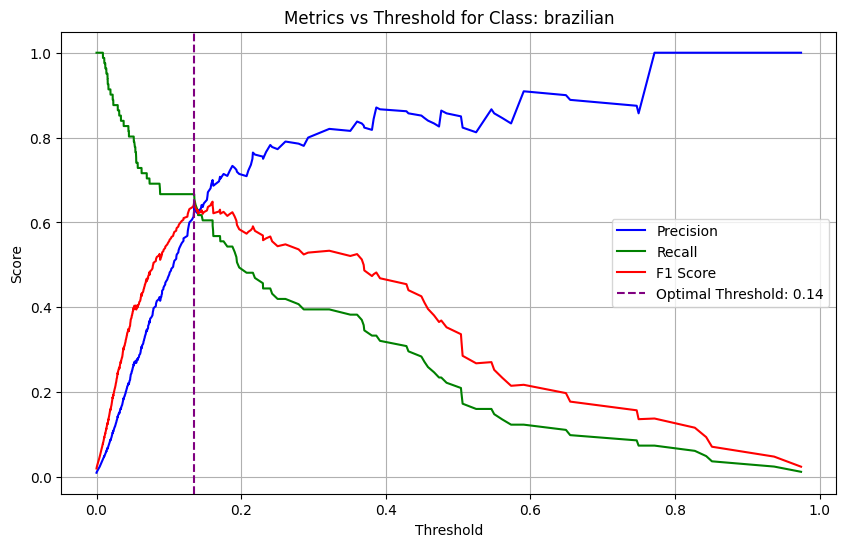

Class: brazilian, Optimal Threshold: 0.14, F1 Score: 0.65


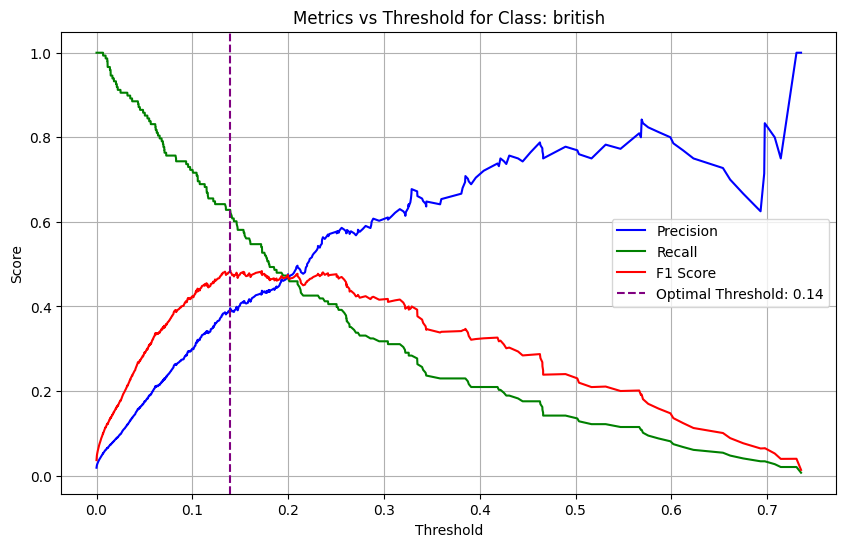

Class: british, Optimal Threshold: 0.14, F1 Score: 0.49


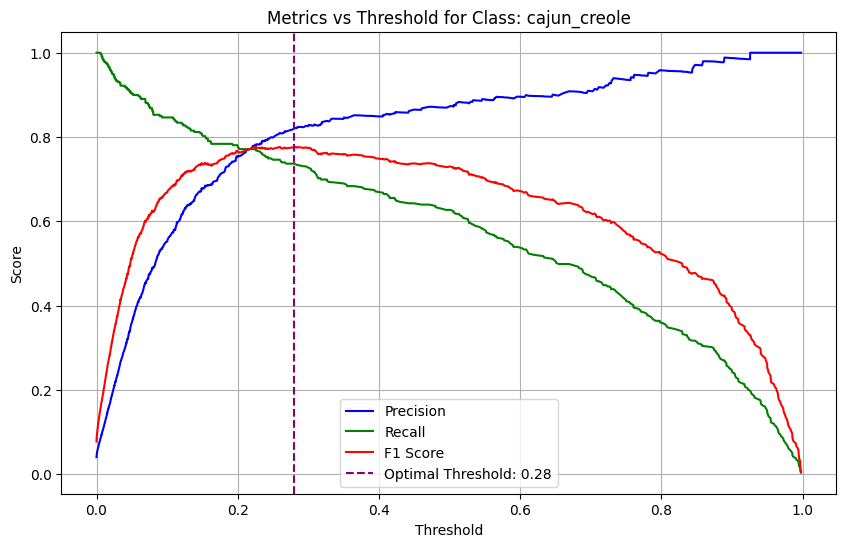

Class: cajun_creole, Optimal Threshold: 0.28, F1 Score: 0.78


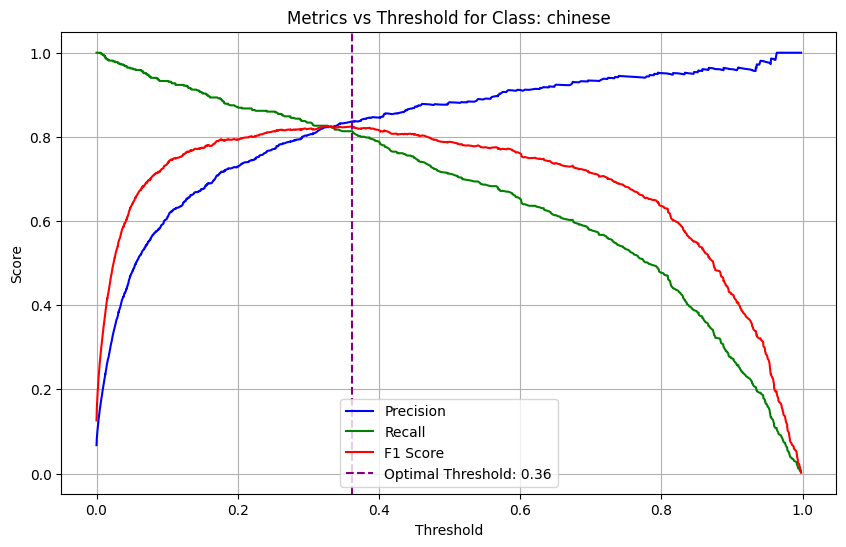

Class: chinese, Optimal Threshold: 0.36, F1 Score: 0.82


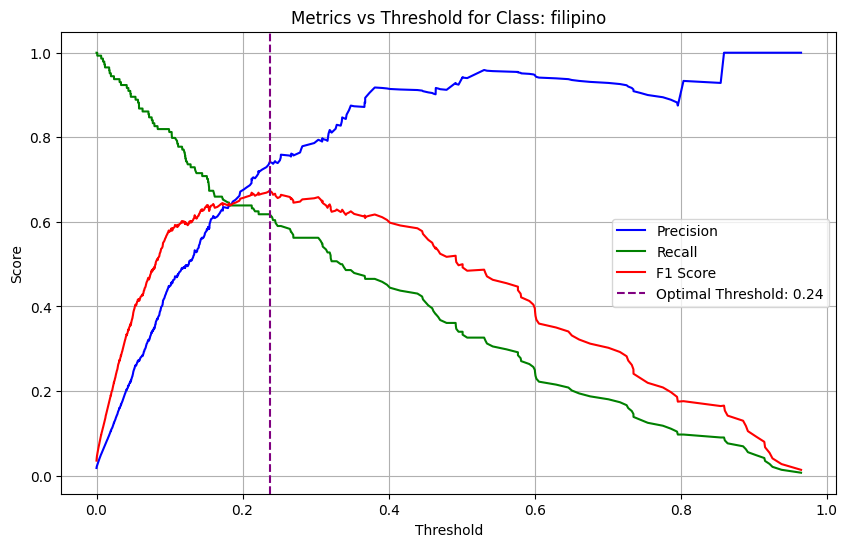

Class: filipino, Optimal Threshold: 0.24, F1 Score: 0.67


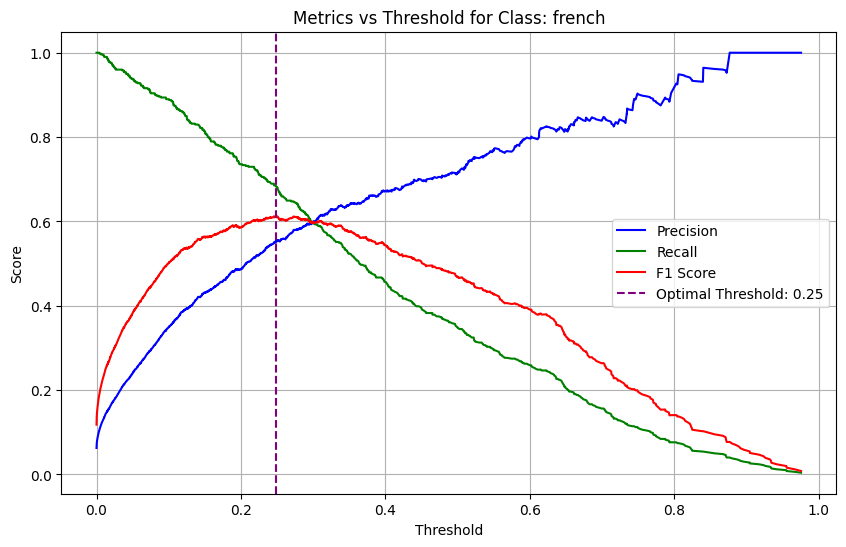

Class: french, Optimal Threshold: 0.25, F1 Score: 0.61


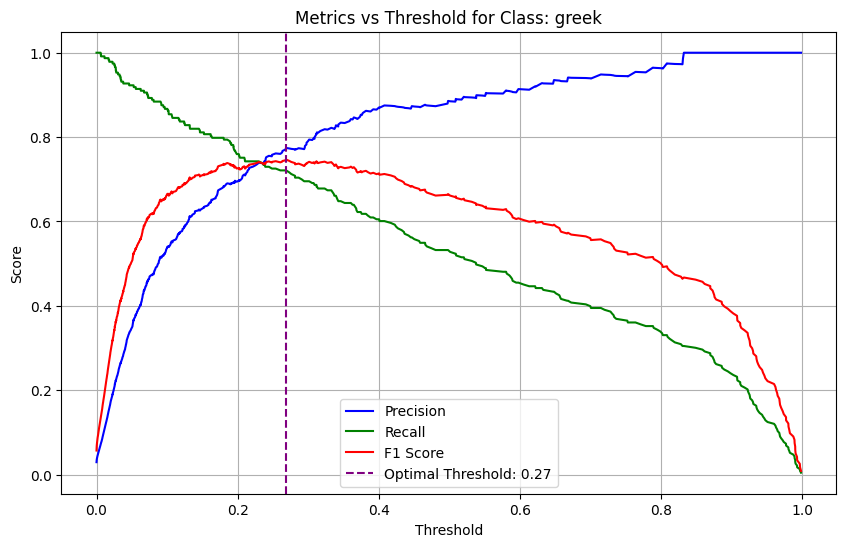

Class: greek, Optimal Threshold: 0.27, F1 Score: 0.75


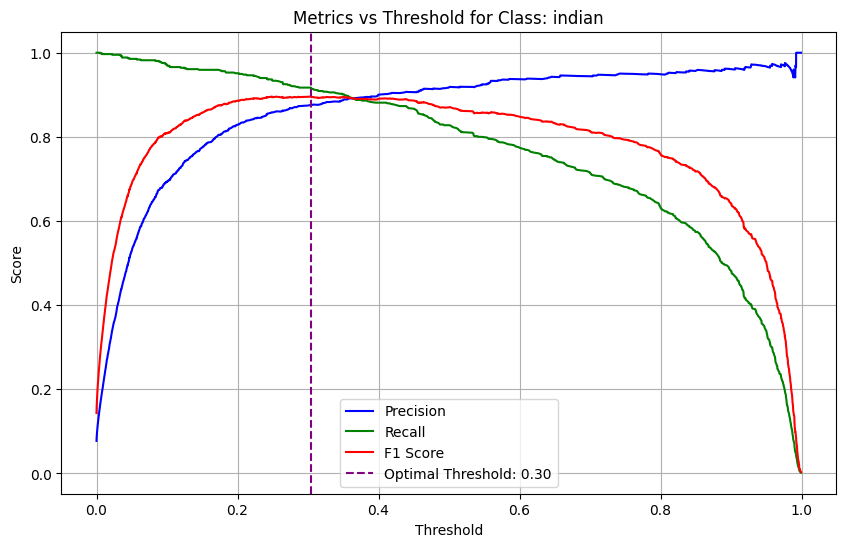

Class: indian, Optimal Threshold: 0.30, F1 Score: 0.90


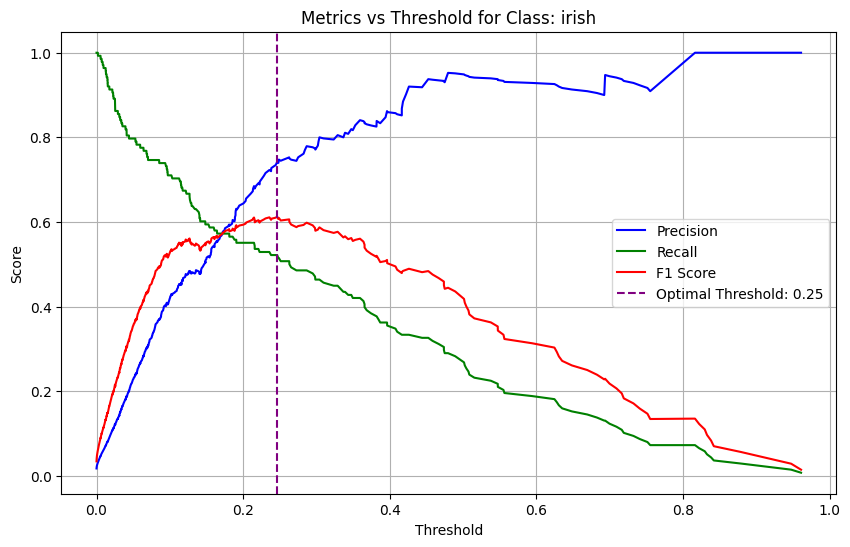

Class: irish, Optimal Threshold: 0.25, F1 Score: 0.61


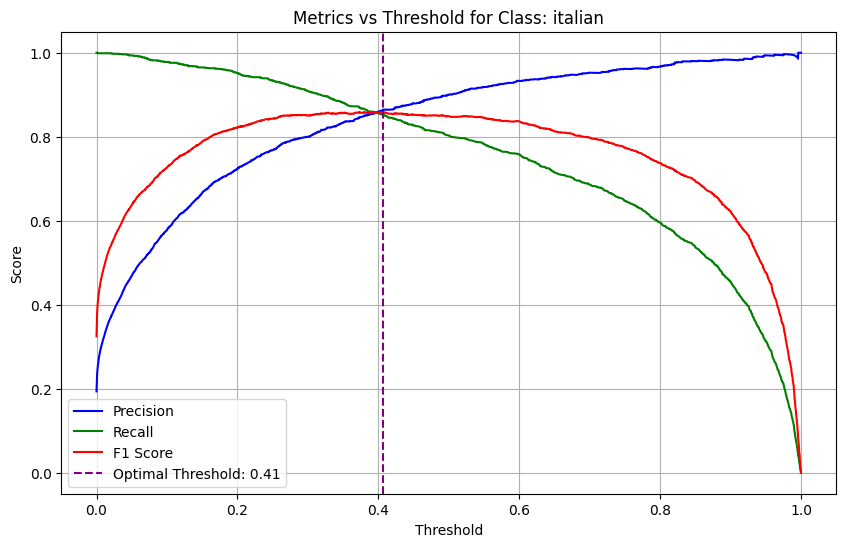

Class: italian, Optimal Threshold: 0.41, F1 Score: 0.86


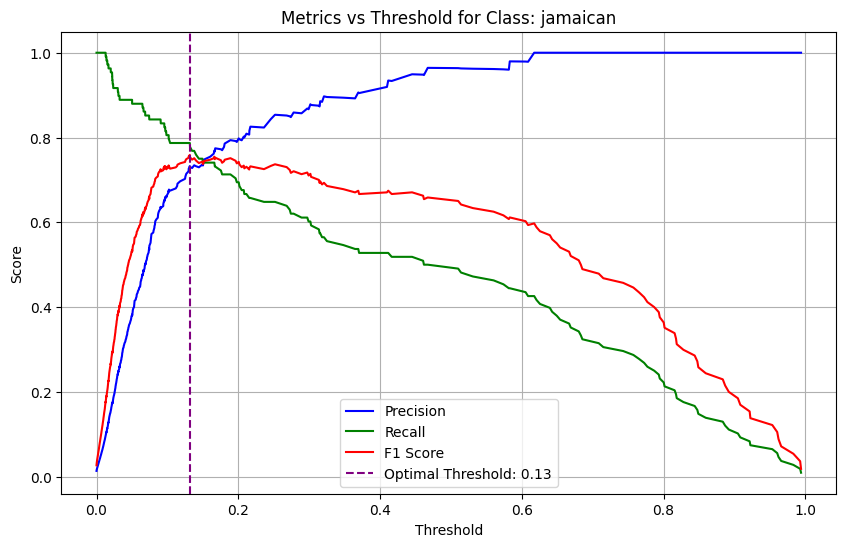

Class: jamaican, Optimal Threshold: 0.13, F1 Score: 0.76


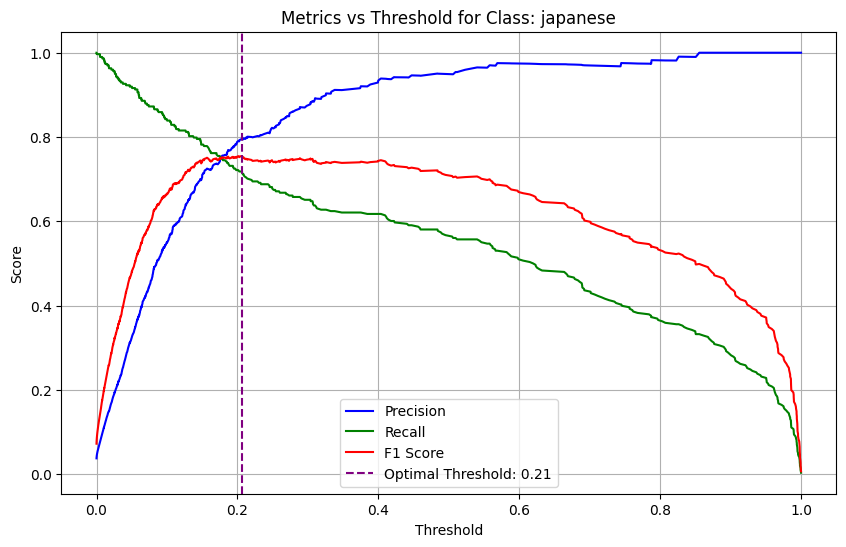

Class: japanese, Optimal Threshold: 0.21, F1 Score: 0.75


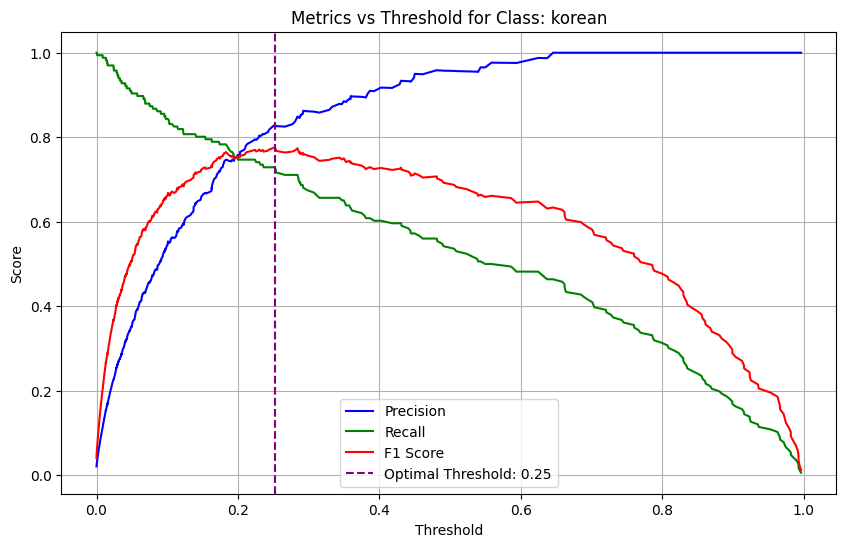

Class: korean, Optimal Threshold: 0.25, F1 Score: 0.78


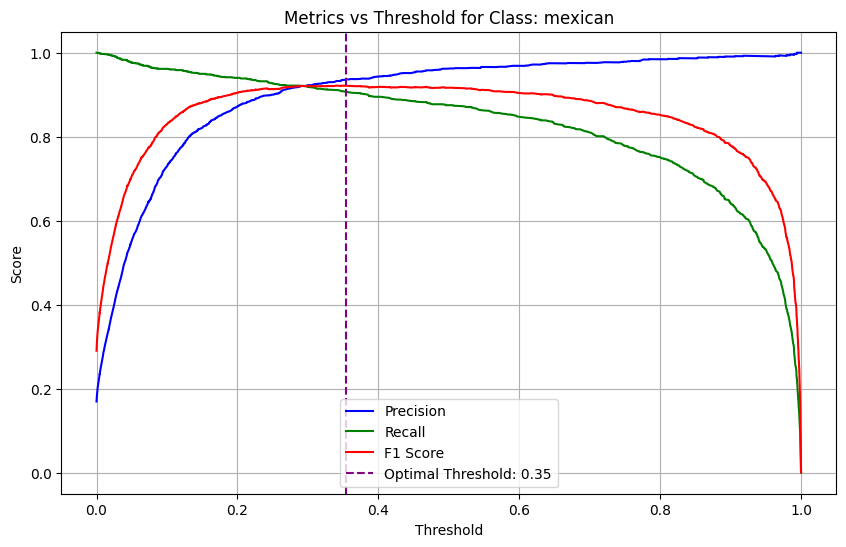

Class: mexican, Optimal Threshold: 0.35, F1 Score: 0.92


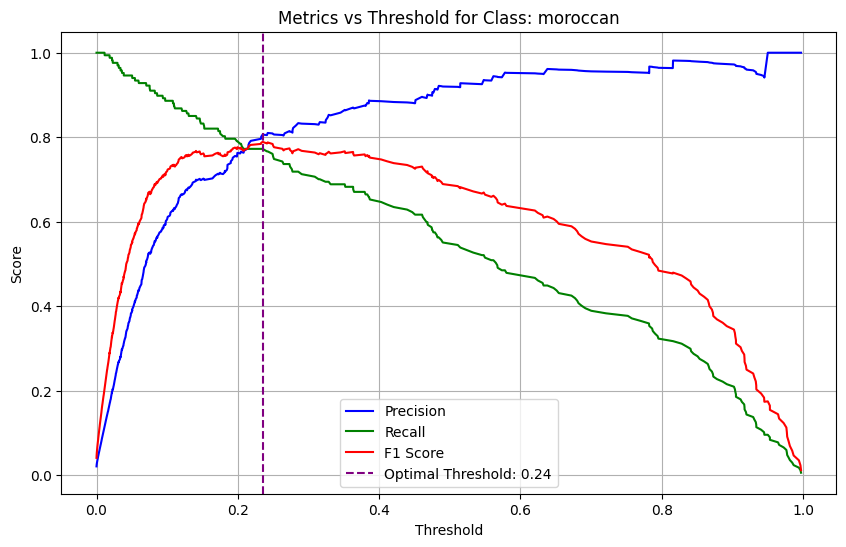

Class: moroccan, Optimal Threshold: 0.24, F1 Score: 0.79


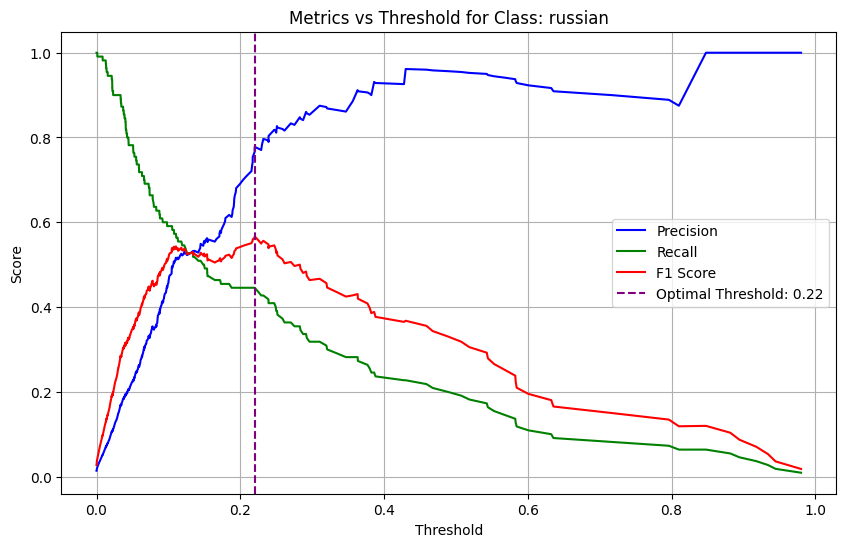

Class: russian, Optimal Threshold: 0.22, F1 Score: 0.57


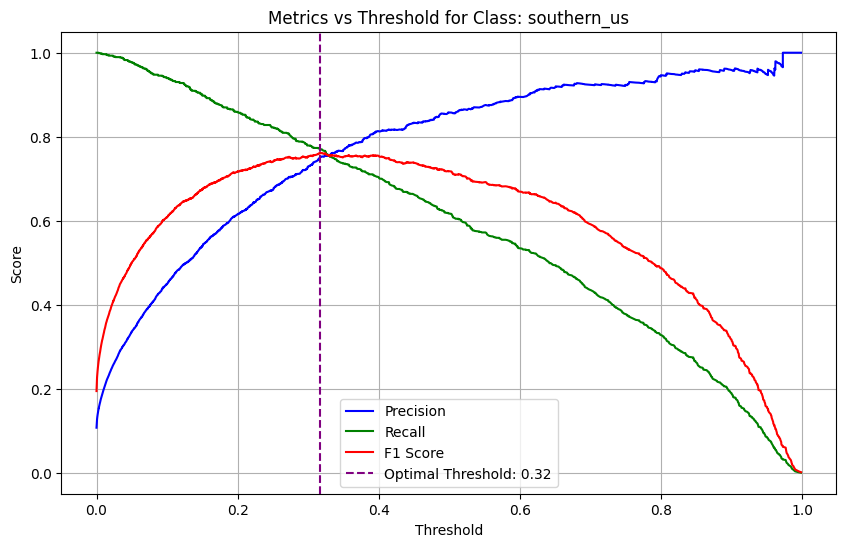

Class: southern_us, Optimal Threshold: 0.32, F1 Score: 0.76


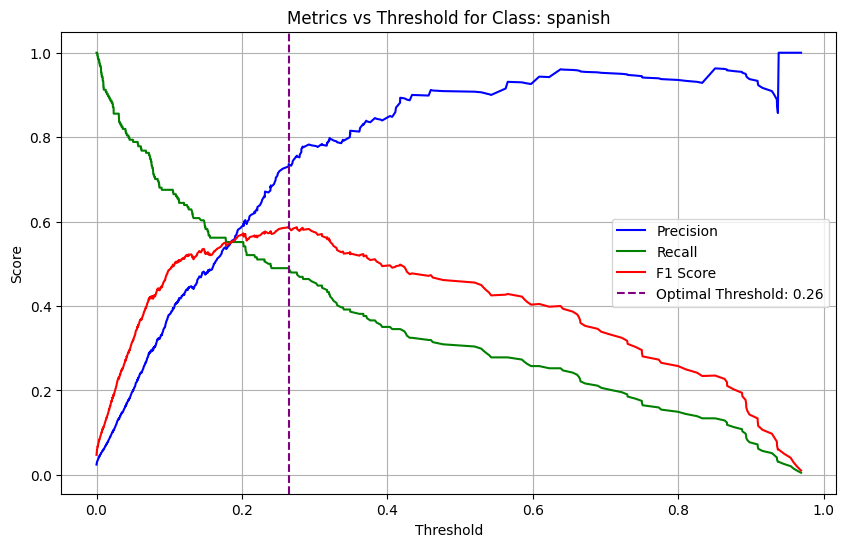

Class: spanish, Optimal Threshold: 0.26, F1 Score: 0.59


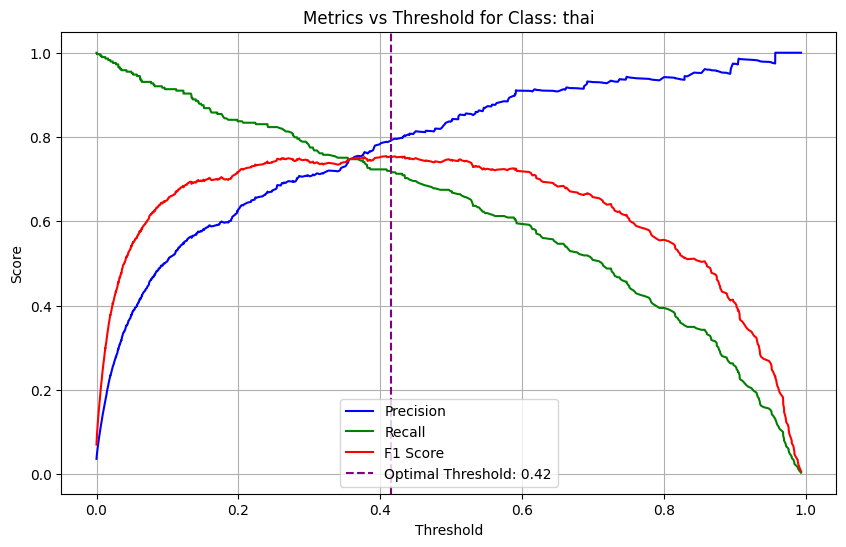

Class: thai, Optimal Threshold: 0.42, F1 Score: 0.75


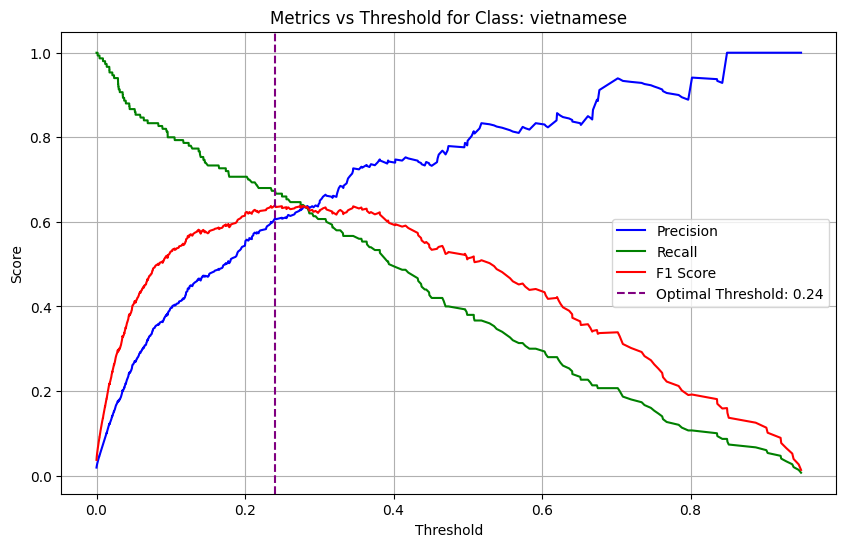

Class: vietnamese, Optimal Threshold: 0.24, F1 Score: 0.64


In [21]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

# Get probabilities and class names
y_proba = pipeline.predict_proba(X_test['ingredients_text'])
class_names = pipeline.classes_

# Store optimal thresholds and their metrics
optimal_thresholds = {}

# Loop through each class
for class_idx, class_name in enumerate(class_names):
    # Binary true labels for this class
    y_true_binary = (y_test == class_name).astype(int)
    y_scores = y_proba[:, class_idx]

    # Compute Precision, Recall, and Thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_true_binary, y_scores)

    # Compute F1 score at each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Avoid division by zero

    # Find threshold with the highest F1 score
    max_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_idx]
    optimal_f1 = f1_scores[max_f1_idx]

    # Save the optimal threshold and its F1 score
    optimal_thresholds[class_name] = optimal_threshold

    # Plot Precision, Recall, and F1
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
    plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
    plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='red')
    plt.axvline(optimal_threshold, color='purple', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Metrics vs Threshold for Class: {class_name}')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Class: {class_name}, Optimal Threshold: {optimal_threshold:.2f}, F1 Score: {optimal_f1:.2f}")


In [22]:
for i in optimal_thresholds.items():
    print(i)

('brazilian', 0.13510429250570127)
('british', 0.1395592665964958)
('cajun_creole', 0.280348295796467)
('chinese', 0.36214327591396694)
('filipino', 0.23712254650905956)
('french', 0.24821384157627233)
('greek', 0.26857929541709785)
('indian', 0.3040114458400579)
('irish', 0.2464323851534967)
('italian', 0.4071273592327998)
('jamaican', 0.13164608182465173)
('japanese', 0.2064260699365704)
('korean', 0.2517828240599811)
('mexican', 0.3539993737739166)
('moroccan', 0.23512015036203276)
('russian', 0.22006999973263583)
('southern_us', 0.3167258881410052)
('spanish', 0.2643859778283418)
('thai', 0.41533515172349333)
('vietnamese', 0.24051247776788276)


In [23]:
def predict_with_custom_thresholds(probas, class_names, thresholds):
    predictions = []
    for probs in probas:
        # Apply custom thresholds to each class probability
        adjusted_probs = [1 if prob >= thresholds[class_name] else 0 for prob, class_name in zip(probs, class_names)]
        # Choose the class with the highest adjusted probability
        if sum(adjusted_probs) > 0:
            predictions.append(class_names[np.argmax(adjusted_probs)])
        else:
            predictions.append(class_names[np.argmax(probs)])  # Fallback to max probability
    return predictions

# Make predictions with custom thresholds
custom_predictions = predict_with_custom_thresholds(y_proba, class_names, optimal_thresholds)

In [24]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Make predictions using custom thresholds
custom_predictions = predict_with_custom_thresholds(y_proba, class_names, optimal_thresholds)

# Evaluate metrics
print("Accuracy:", accuracy_score(y_test, custom_predictions))

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, custom_predictions, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, custom_predictions, labels=class_names)
print("\nConfusion Matrix:")
print(conf_matrix)


Accuracy: 0.7849151477058454

Classification Report:
              precision    recall  f1-score   support

   brazilian       0.62      0.67      0.64        81
     british       0.39      0.63      0.48       148
cajun_creole       0.79      0.74      0.76       319
     chinese       0.81      0.85      0.83       536
    filipino       0.72      0.60      0.65       144
      french       0.55      0.68      0.61       499
       greek       0.76      0.72      0.74       233
      indian       0.87      0.93      0.90       615
       irish       0.72      0.44      0.55       138
     italian       0.81      0.87      0.84      1545
    jamaican       0.78      0.68      0.73       108
    japanese       0.81      0.67      0.74       298
      korean       0.93      0.68      0.79       166
     mexican       0.91      0.93      0.92      1354
    moroccan       0.86      0.72      0.79       167
     russian       0.77      0.40      0.53       110
 southern_us       0.74     

In [25]:
import pandas as pd

# Assuming `test_data` is your test dataset
# Extract probabilities for the test data
test_proba = pipeline.predict_proba(test_data['ingredients_text'])

# Make predictions using custom thresholds
test_predictions = predict_with_custom_thresholds(test_proba, class_names, optimal_thresholds)

# Create a DataFrame with the index and predicted cuisine
output_df = pd.DataFrame({
    "id": test_data['id'],  # Ensure the index column matches the test data
    "cuisine": test_predictions
})

# Save to CSV
output_file = "test_predictions.csv"
output_df.to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")

Predictions saved to test_predictions.csv


0.77152 on leaderboard

## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [27]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text to numerical features
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=64))  # Random Forest Classifier
])

In [28]:
pipeline.fit(X_train['ingredients_text'], y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier(random_state=64))])

In [29]:
# Predict on test data
y_pred = pipeline.predict(X_test['ingredients_text'])

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.75
              precision    recall  f1-score   support

   brazilian       0.86      0.37      0.52        81
     british       0.72      0.20      0.31       148
cajun_creole       0.81      0.68      0.74       319
     chinese       0.73      0.86      0.79       536
    filipino       0.80      0.47      0.59       144
      french       0.54      0.50      0.52       499
       greek       0.87      0.54      0.67       233
      indian       0.82      0.93      0.88       615
       irish       0.85      0.36      0.51       138
     italian       0.70      0.92      0.80      1545
    jamaican       0.94      0.47      0.63       108
    japanese       0.85      0.59      0.70       298
      korean       0.91      0.62      0.74       166
     mexican       0.85      0.93      0.89      1354
    moroccan       0.87      0.64      0.74       167
     russian       0.82      0.25      0.38       110
 southern_us       0.64      0.77      0.69       861
     spanish

In [30]:
# Predict using test data
y_pred = pipeline.predict(test_data['ingredients_text'])

# Prepare the output DataFrame
output_df = pd.DataFrame({
    'id': test_data['id'],          # Ensure the test data has an 'id' column
    'cuisine': y_pred            # Predicted labels
})

# Save predictions to CSV
output_file = "test_predictions.csv"
output_df.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")

Predictions saved to test_predictions.csv


0.74497 on leaderboard

## Support Vector Machine

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [35]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),   # Convert text to TF-IDF features
    ('classifier', SVC(kernel='linear', probability=True, random_state=64))  # Support Vector Machine
])

In [36]:
# Train the model on the training data
pipeline.fit(X_train['ingredients_text'], y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test['ingredients_text'])

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))

Accuracy: 0.78
              precision    recall  f1-score   support

   brazilian       0.71      0.56      0.62        81
     british       0.52      0.44      0.48       148
cajun_creole       0.83      0.72      0.77       319
     chinese       0.79      0.84      0.82       536
    filipino       0.76      0.65      0.70       144
      french       0.53      0.60      0.57       499
       greek       0.77      0.68      0.72       233
      indian       0.87      0.93      0.90       615
       irish       0.67      0.48      0.56       138
     italian       0.79      0.89      0.84      1545
    jamaican       0.84      0.67      0.74       108
    japanese       0.87      0.67      0.76       298
      korean       0.90      0.72      0.80       166
     mexican       0.91      0.92      0.92      1354
    moroccan       0.85      0.75      0.80       167
     russian       0.72      0.45      0.56       110
 southern_us       0.71      0.79      0.75       861
     spanish

### Grid Search, Hyperparameter Tuning

In [37]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10],        # Regularization strength
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto'],
}

# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,                  # 3-fold cross-validation
    scoring='accuracy',    # Evaluate using accuracy
    verbose=1,
    n_jobs=-1              # Parallelize search
)

# Fit grid search
grid_search.fit(X_train['ingredients_text'], y_train)

# Print best parameters and accuracy
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.2f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best Accuracy: 0.80


In [39]:
# Get the best estimator
best_model = grid_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(test_data['ingredients_text'])

# Save predictions to CSV
output_df = pd.DataFrame({
    'id': test_data['id'],      # Ensure 'id' exists in X_test
    'cuisine': y_pred
})
output_df.to_csv('svm_predictions.csv', index=False)
print("Predictions saved to svm_predictions.csv")

Predictions saved to svm_predictions.csv
